# **Problem 1**

(a) Create an image SEG1 containing artificial objects on a background of
constant gray-level. Generate simple geometric objects such as squares,
rectangles, diamonds, stars, circles, etc., each having a constant gray-level
different from that of the background, some of them darker and some brighter
than the background. Determine the area of each object and store it in an
appropriate form.

I have created a rectangle, a square and a circle.
There respective areas are -  

Rectangle = 12500   
Square = 10000  
Circle = 31397

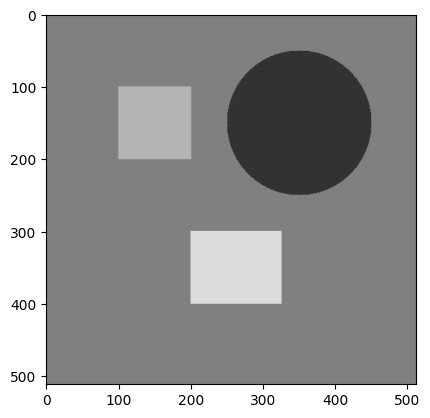

In [297]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

size = (512, 512)
background_color = (128, 128, 128)
seg1 = np.ones((size[0], size[1], 3), dtype=np.uint8) * background_color
seg1 = np.ascontiguousarray(seg1, dtype=np.uint8)

light_gray = (180, 180, 180)
dark_gray = (220, 220, 220)
darker_gray = (50, 50, 50)

Shape = namedtuple('Shape', ['name', 'size', 'position', 'color', 'area'])

square = Shape('Square', (100,100), (100,100), light_gray, -1)
square = square._replace(area = square.size[0] * square.size[1])

circle = Shape('Circle', 100, (350,150), darker_gray, -1)


rectangle = Shape('Rectangle', (125,100), (200,300), dark_gray, -1)
rectangle = rectangle._replace(area = rectangle.size[0] * rectangle.size[1])

cv2.rectangle(seg1, rectangle.position, (rectangle.position[0] + rectangle.size[0], rectangle.position[1] + rectangle.size[1]), rectangle.color, -1)
cv2.rectangle(seg1, square.position, (square.position[0] + square.size[0], square.position[1] + square.size[1]), square.color, -1)
cv2.circle(seg1, circle.position, circle.size, circle.color, -1)

circle_area = np.sum(seg1 == (50,50,50))/3
circle = circle._replace(area=circle_area)
# print(circle_area)

plt.imshow(seg1, cmap='gray')
plt.show()

In [298]:
print("Rectangle Area : {}".format(rectangle.area))
print("Square Area : {}".format(square.area))
print("Circle Area : {}".format(circle.area))

Rectangle Area : 12500
Square Area : 10000
Circle Area : 31417.0


(b) Superimpose additive Gaussian noise with a given standard deviation, thus
creating an image SEG2.

I have used standard deviation of 10 to generate a gaussian image and superimposed that image onto the previous image

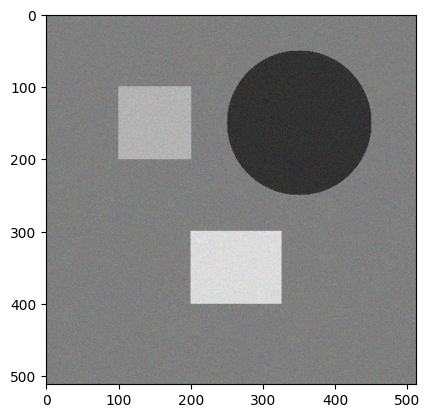

In [299]:
def addGaussian(std, orig_img):
# std_dev = 10
  gaussian_noise = np.random.normal(loc=0, scale=std, size=orig_img.shape)
  seg2 = np.clip(orig_img + gaussian_noise, 0, 255).astype(np.uint8)
  return seg2

std_dev = 10
seg2 = addGaussian(std_dev, seg1)
plt.imshow(seg2, cmap='gray')
plt.show()

(c)Superimpose random impulse noise of a given severity over the image SEG2,
thus creating an image SEG3.

I have used severity of 0.10 (10 $\%$ of the pixels will be corrupted) and superimposed random impulse noises onto the image (like salt and pepper noise).

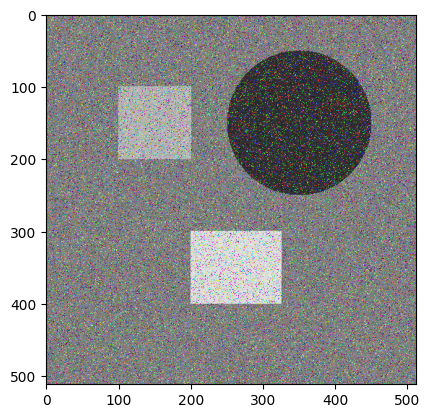

In [300]:
def addImpulse(severity, orig_img):
# severity = 0.10
  impulse_noise = np.random.rand(*orig_img.shape)

  seg3 = orig_img.copy()
  seg3[impulse_noise < severity/2] = 0
  seg3[impulse_noise > 1 - severity/2] = 255
  return seg3

severity = 0.10
seg3 = addImpulse(severity, seg2)
plt.imshow(seg3, cmap='gray')
plt.show()

By varying the shapes of the objects, standard deviation of the Gaussian additive
noise, and severity of the impulse noise, sets of controlled properties can be
generated. To create a simple set of images for segmentation experiments, make
a single image SEG1, apply three levels of Gaussian additive noise, and three
levels of impulse noise. You will obtain a set of ten images that will be used in the
segmentation problems below.

I have used standard deviations 5, 10, and 100 and severity of impulse noises as 0.05, 0.10 and 0.20.

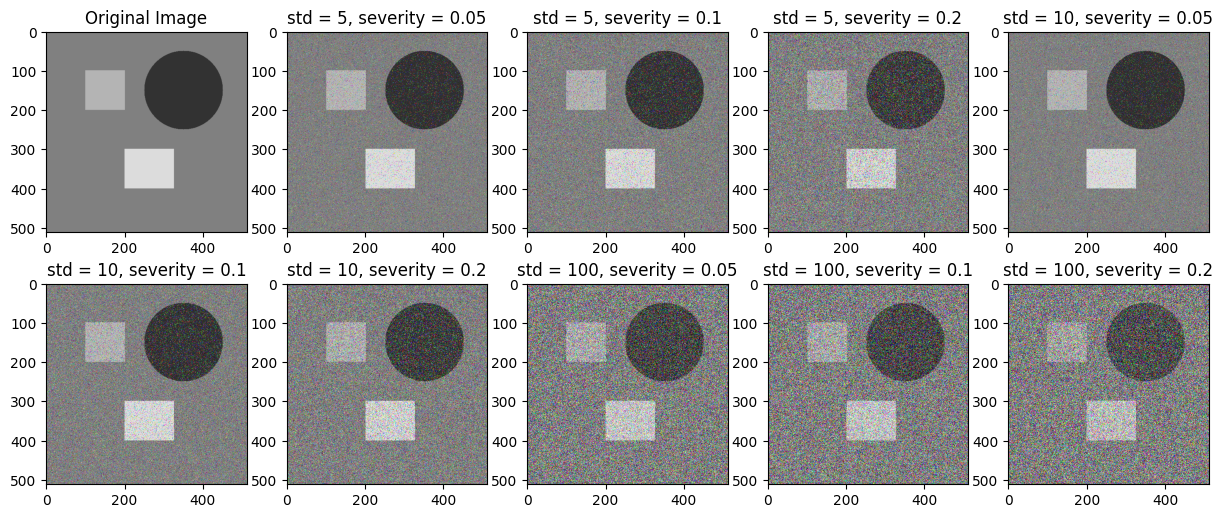

In [301]:
gaussian_std = [5,10,100]
impulse_severity = [0.05, 0.10, 0.20]

image_sets = []

fig, axs = plt.subplots(2,5, figsize=(15, 6))
i = j = 0
axs[i][j].imshow(seg1, cmap='gray')
axs[i][j].set_title('Original Image')
j+=1
# subplots = 1

ImageInfo = namedtuple('ImageInfo', ['image', 'std', 'severity'])

seg1_info = ImageInfo(seg1, 0, 0)
image_sets.append(seg1_info)

for std in gaussian_std:
  for svrty in impulse_severity:
    img = addGaussian(std, seg1)
    img2 = addImpulse(svrty, img)
    img2_info = ImageInfo(img2, std, svrty)
    image_sets.append(img2_info)

    if j == 5:
      j = 0
      i = 1
    axs[i][j].imshow(img2, cmap='gray')
    axs[i][j].set_title('std = {}, severity = {}'.format(std, svrty))
    j += 1
    # subplots+=1




---



---



---



# **Problem 2**

To assess the correctness of a segmentation, a set of measures must be
developed to allow quantitative comparison among methods. Develop a program
for calculating the following two segmentation accuracy indices:

(a) "Relative signed area error" is expressed in percent and computed as:

\begin{align*}
A_{\text{error}} = \frac{\sum_{i=1}^N T_i - \sum_{j=1}^M A_j}{\sum_{i=1}^N T_i} * 100
\end{align*}

where $T_i$
is the true area of the i-th object and $A_j$
is the measured area of the
j-th object, N is the number of objects in the image, M is the number of objects
after segmentation. Areas may be expressed in pixels.

It was slightly unclear what is meant by the area of the object. Because, after adding the noise, the boundaries of objects can be distorted. So I have considered segmentation as a task of separating foreground (original objects - squares, rectangles, etc) from background (gray-level). Therefore,

\begin{align*}
\sum_{j=1}^M A_j = \text{Total Image Area - Segmented Background}
\end{align*}

In [302]:
def getRelSignedError(origImage, segImage):
  grayscale_orig = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY)
  total_true_area = rectangle.area + circle.area + square.area
  # segmented_rectangle_area = np.sum(segImage[300:300+100,200:200+125] == 1)
  # segmented_square_area = 
  total_measured_area = segImage.shape[0] * segImage.shape[1] - np.sum(segImage == 0)
  error = (total_true_area - total_measured_area) * 100.0/ total_true_area
  return error

(b) "Labelling error" (denoted as $L_{\text{error}}$) is defined as the ratio of the number of incorrectly labeled pixels (object pixels labeled as background as vice versa) and the number of pixels of true objects $\sum_{i=1}^N T_i$ according to prior knowledge, and is expressed as percent. (20 points)

Labelling error was simple to compute. I just changed the original image into foreground and background and subtracted the segmented image from this (both images are binary now). Then I simply counted no of pixels that are non-zero (object pixels labeled as background + background pixels labeled as object)

In [330]:
def getLabellingError(origImage, segImage):
  grayscale_orig = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY)
  # grayscale_seg = cv2.cvtColor(segImage, cv2.COLOR_BGR2GRAY)
  grayscale_orig[grayscale_orig == 128] = 0
  grayscale_orig[grayscale_orig != 0] = 1
  diff_image = grayscale_orig - segImage
  total_true_area = rectangle.area + circle.area + square.area
  return np.sum(diff_image != 0) * 100.0 / total_true_area



---



---



---



# Problem 3
Implement the following methods for segmentation and apply to the test
images created in Problem 1. For each method and each image, quantitatively
assess the segmentation accuracy using the indices developed in Problem 2.
Compare the segmentation accuracy for individual methods.  

(a) Basic thresholding.

For the original image, basic thresholding was easy to do. Any pixel intensity that is not 128 is foreground, otherwise background. For the noise affected images, I have used a constant threshold of 140.

---------------------------------------------------------------------------------------------------
|  Gaussian Noise        | Impulse               | Relative Signed Error  | Labelling Error        |
---------------------------------------------------------------------------------------------------
|  0                     | 0                     | -0.7919580095331713    | 0.0                    |
|  5                     | 0.05                  | 25.340801602463046     | 16.262054443359375     |
|  5                     | 0.1                   | 2.7931821132481405     | 21.228408813476562     |
|  5                     | 0.2                   | -36.59884637498377     | 29.909515380859375     |
|  10                    | 0.05                  | 16.814733757441996     | 19.091415405273438     |
|  10                    | 0.1                   | -3.39781516033904      | 23.402023315429688     |
|  10                    | 0.2                   | -39.05076321011926     | 30.99517822265625

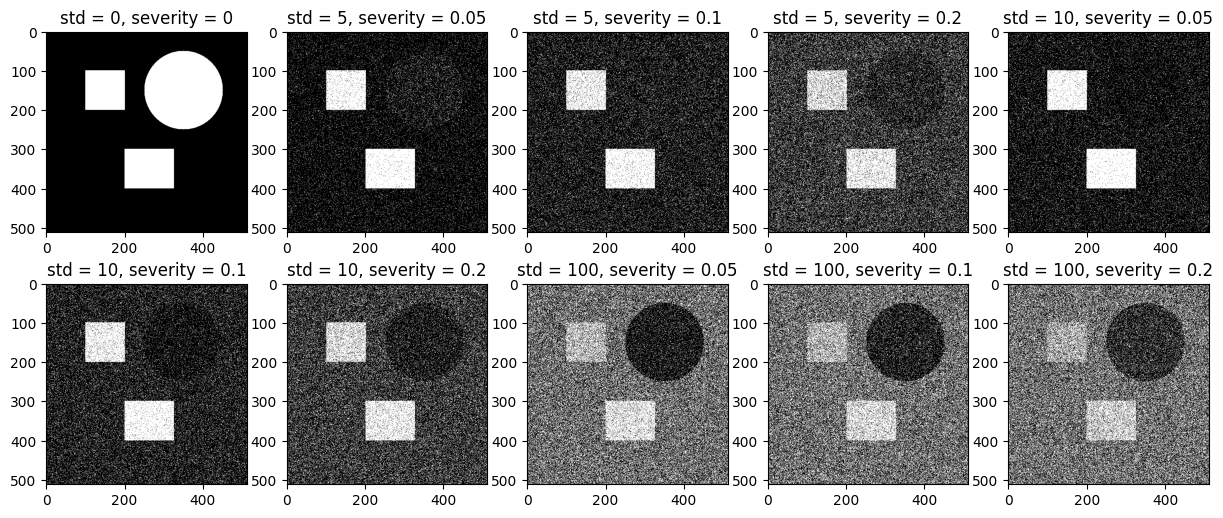

In [332]:
import cv2

def basicThresholding(image, threshold_value, idx):
  grayscale_orig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  max_value = 255
  if idx == 0:
    thresholded_image = grayscale_orig.copy()
    thresholded_image[thresholded_image <= 127] = 255
    thresholded_image[thresholded_image >= 129] = 255
    thresholded_image[thresholded_image == 128] = 0
    thresholded_image[thresholded_image == 255] = 1
    return thresholded_image
  else:
    thresholded_image = grayscale_orig.copy()
    thresholded_image[thresholded_image == 50] = 255
    thresholded_image[thresholded_image >= 140] = 255
    thresholded_image[thresholded_image < 140] = 0
    thresholded_image[thresholded_image == 255] = 1
    return thresholded_image
    # thresholded_image = cv2.threshold(grayscale_orig, threshold_value, max_value, cv2.THRESH_BINARY)[1]
    # thresholded_image[thresholded_image == 255] = 1
    # return thresholded_image

fig, axs = plt.subplots(2,5, figsize=(15, 6))
i = j = 0

# print("|  Gaussian Noise  | Impulse | Relative Signed Error | Labelling Error |")
print("---------------------------------------------------------------------------------------------------")
print("|  {:<20}  | {:<20}  | {:<21}  | {:<21}  |".format("Gaussian Noise", "Impulse", "Relative Signed Error", "Labelling Error"))
print("---------------------------------------------------------------------------------------------------")

for k in range(len(image_sets)):
  thresholded_image = basicThresholding(image_sets[k].image, 140, k)
  rel_signed_area_error = getRelSignedError(image_sets[0].image, thresholded_image)
  labelling_error = getLabellingError(image_sets[0].image, thresholded_image)
  if j == 5:
    j = 0
    i = 1
  axs[i][j].imshow(thresholded_image, cmap='gray')
  axs[i][j].set_title('std = {}, severity = {}'.format(image_sets[k].std, image_sets[k].severity))
  j += 1
  print("|  {:<20}  | {:<20}  | {:<21}  | {:<21}  |".format(image_sets[k].std, image_sets[k].severity, rel_signed_area_error, labelling_error))
  # print("|  {}  | {}  | {}  | {}  |".format(image_sets[k].std, image_sets[k].severity, labelling_error))
  # print("Gaussian noise of std {}, and impulse severity {}, Relative Signed Area Error is {}".format(image_sets[k].std, image_sets[k].severity, rel_signed_area_error))
  # print("Gaussian noise of std {}, and impulse severity {}, Labelling Error is {}".format(image_sets[k].std, image_sets[k].severity, labelling_error))

print("---------------------------------------------------------------------------------------------------")

### **Analysis**

For the first image when there is no noise, we can see that the segmentation is perfect. For later images, I have used simple thresholding (intensity is 255 if value above a certain threshold and 0 otherwise).

**Labelling Error** : Keeps on increasing as expected because of noise.  
**Relative Signed Area Error** : The general trend is that the relative signed area error is also increasing as expected because of noise. Because of the randomness of impulses, sometimes the segmented foreground is more than the actual foreground (in case of noisy images), so this error can be negative as well. It have even reached beyond 100 % which means that the segmented foreground area is more than 2 times the actual foreground area.

(b) Chan-Vese Segmentation

I have used the library function from skimage. One important thing to note is to control the parameters - $\lambda_1$ and $\lambda_2$. Since $\lambda_1$ controls the smoothness, I have increased it's value from default 1 to 2 in case of noise, so that the segmented image is smooth. However, in case of original image (without any noise), I have used a larger value for $\lambda_2$ to improve the fitting.

---------------------------------------------------------------------------------------------------
|  Gaussian Noise        | Impulse               | Relative Signed Error  | Labelling Error        |
---------------------------------------------------------------------------------------------------
|  0                     | 0                     | -7.333494074225198     | 1.3454437255859375     |
|  5                     | 0.05                  | 38.75586549696756      | 8.654403686523438      |
|  5                     | 0.1                   | 38.7818313333457       | 8.671188354492188      |
|  5                     | 0.2                   | 39.23994287515997      | 8.76922607421875       |
|  10                    | 0.05                  | 38.72433555279411      | 8.66241455078125       |
|  10                    | 0.1                   | 38.75401079436912      | 8.673095703125         |
|  10                    | 0.2                   | 39.61644750264295      | 8.839797973632812

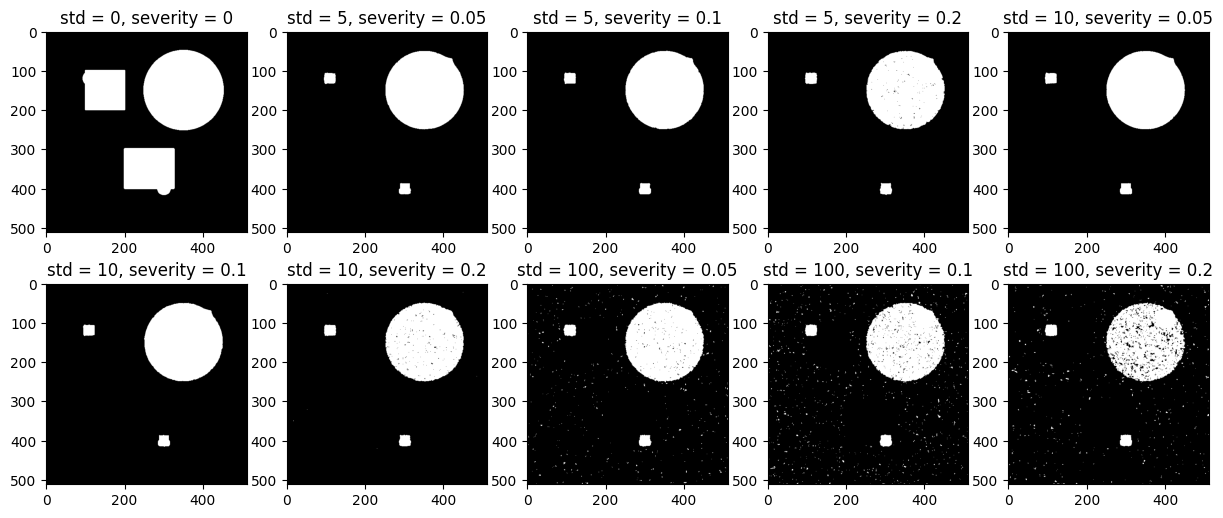

In [344]:
from skimage.segmentation import chan_vese
import skimage

def chanVeseSegmentation(origImage, lambda1=1, lambda2=1):
  grayscale_orig = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY)
  contour = np.zeros_like(grayscale_orig)
  rr1, cc1 = skimage.draw.disk((90,400),20)
  rr2, cc2 = skimage.draw.disk((120,110),13)
  rr3, cc3 = skimage.draw.disk((400,300), 13)
  contour[rr1, cc1] = 1
  contour[rr2, cc2] = 1
  contour[rr3, cc3] = 1
  cv = chan_vese(grayscale_orig, mu=1, lambda1=lambda1, lambda2=lambda2, tol=1e-3,
               max_num_iter=1000, dt=0.5, init_level_set=contour,
               extended_output=True)
  return cv[0]


fig, axs = plt.subplots(2,5, figsize=(15, 6))
i = j = 0

lambda1 = 1
lambda2 = 1

print("---------------------------------------------------------------------------------------------------")
print("|  {:<20}  | {:<20}  | {:<21}  | {:<21}  |".format("Gaussian Noise", "Impulse", "Relative Signed Error", "Labelling Error"))
print("---------------------------------------------------------------------------------------------------")

for k in range(len(image_sets)):
  if k == 0:
    lambda1 = 1
    lambda2 = 2
  else:
    lambda1 = 2
    lambda2 = 1.5
  thresholded_image = chanVeseSegmentation(image_sets[k].image, lambda1, lambda2)
  thresholded_image[thresholded_image == 1] = 255
  rel_signed_area_error = getRelSignedError(image_sets[0].image, thresholded_image)
  labelling_error = getLabellingError(image_sets[0].image, thresholded_image)
  if j == 5:
    j = 0
    i = 1
  axs[i][j].imshow(thresholded_image, cmap='gray')
  axs[i][j].set_title('std = {}, severity = {}'.format(image_sets[k].std, image_sets[k].severity))
  j += 1
  print("|  {:<20}  | {:<20}  | {:<21}  | {:<21}  |".format(image_sets[k].std, image_sets[k].severity, rel_signed_area_error, labelling_error))

  # print("Gaussian noise of std {}, and impulse severity {}, Relative Signed Area Error is {}".format(image_sets[k].std, image_sets[k].severity, rel_signed_area_error))
  # print("Gaussian noise of std {}, and impulse severity {}, Labelling Error is {}".format(image_sets[k].std, image_sets[k].severity, labelling_error))


### **Analysis**

**Labelling Error** : Keeps on increasing as expected because of noise. However the rate of increment is extremely low.  
**Relative Signed Area Error** : Here, we can see that it is again increasing but the rate of increment is extremely low as compared to thresholding.

### **Comparison**

We can clearly see the benefits of Chan-Vese as it is performing well even after adding noise. After corrupting 20 % image signals also, the labelling error is near 10 %. Also, the relative signed error is well within control as compared to thresholding where it started crossing even 100 %. However, the Chan-Vese is sensitive to hyper-parameters - $λ_1$ and $λ_2$. So, we have to spend some time configuring this particular parameter.



---



---



---



# **Problem 4**

Take the image heart.jpg and rotate it 15 degrees. Call the new image
heart.15.jpg. Align (register the images) using a rigid registration method.
Explicitly explain your method. You may any package that you like, just give all
the details. (20 points)

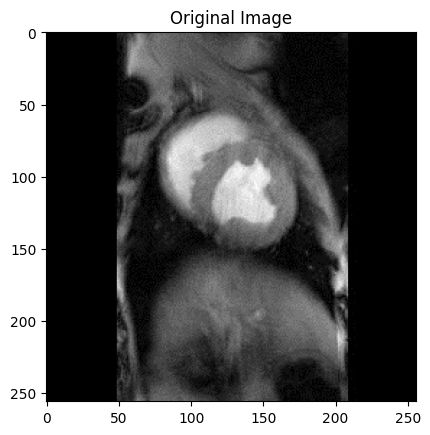

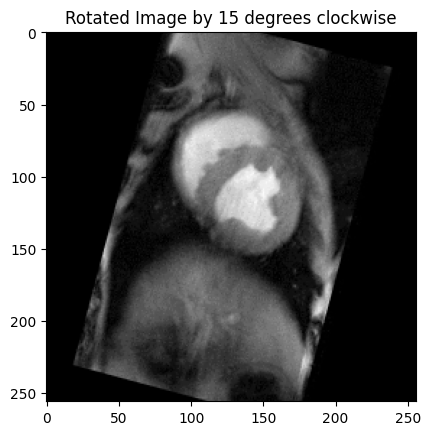

True

In [353]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from skimage.transform import rotate
import math

img = cv2.imread('heart.jpg')
h, w, _ = img.shape
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

angle = -15.0
rotation_matrix = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)

rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
plt.imshow(rotated_img, cmap='gray')
plt.title('Rotated Image by 15 degrees clockwise')
plt.show()

cv2.imwrite('heart.15.jpg', rotated_img)

### **Algorithm**

I am using SIFT features and RANSAC algorithm to find the homography matrix.  
- **Step 1 (5pt)**. Used the function from SIFT class to detect keypoints from the given image.  

- **Step 2 (10pt)**. Rotated the image clockwise by 15 degrees. Extracted SIFT keypoints for this rotated image.

- **Step 3 (15pt)**. Matched the SIFT keypoints of the original image and the rotated imag using the `knnMatch` function in the `cv2.BFMatcher` class. 

- **Step 4 (10pt)**. Used the RANSAC algorithm to find the affine transformation from the rotated image to the original image. 

Text(0.5, 1.0, 'Transformed Image')

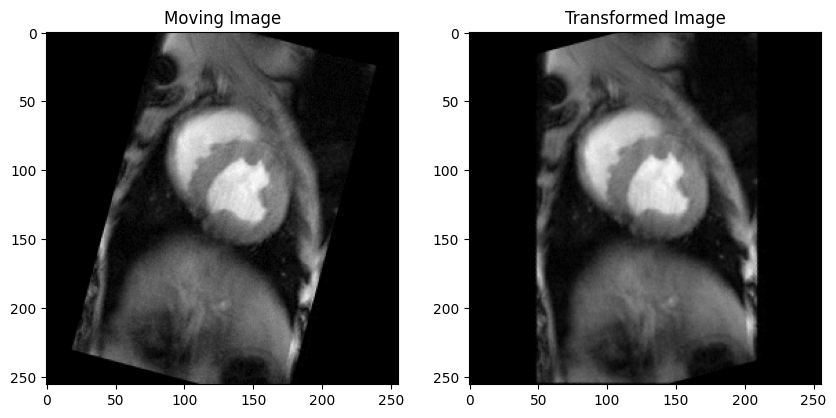

In [372]:
fixed_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
moving_image = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, d1 = sift.detectAndCompute(moving_image, None)
kp2, d2 = sift.detectAndCompute(fixed_image, None)

# BFMatcher with default params
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(d1, d2, k=2)

# matches.sort(key = lambda x: x[0].distance)

good_matches = []
for point1, point2 in matches:
  if point1.distance < 0.1*point2.distance:
    good_matches.append(point1)

# Get 90% of the matching points
# matches = matches[:int(len(matches)*0.9)]
no_of_matches = len(good_matches)


p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

# Extract corresponding fixed and moving image points
# for i in range(len(matches)):
i = 0
for m in good_matches:
  p1[i, :] = kp1[m.queryIdx].pt
  p2[i, :] = kp2[m.trainIdx].pt
  i += 1
# Compute the homography matrix using RANSAC
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# Apply the homographhy matrix on the moving image
transformed_img = cv2.warpPerspective(moving_image, homography, (moving_image.shape[1], moving_image.shape[0]))

fig, axs = plt.subplots(1,2, figsize=(10, 6))

axs[0].imshow(moving_image, cmap='gray')
axs[0].set_title('Moving Image')

axs[1].imshow(transformed_img, cmap='gray')
axs[1].set_title('Transformed Image')



---



---



---



# **Problem 5**

I have computed the second derivating of the given image in x and y direction. However, I simply could have used Laplacian operator as well. Although, it doesn't matter as both does same job.

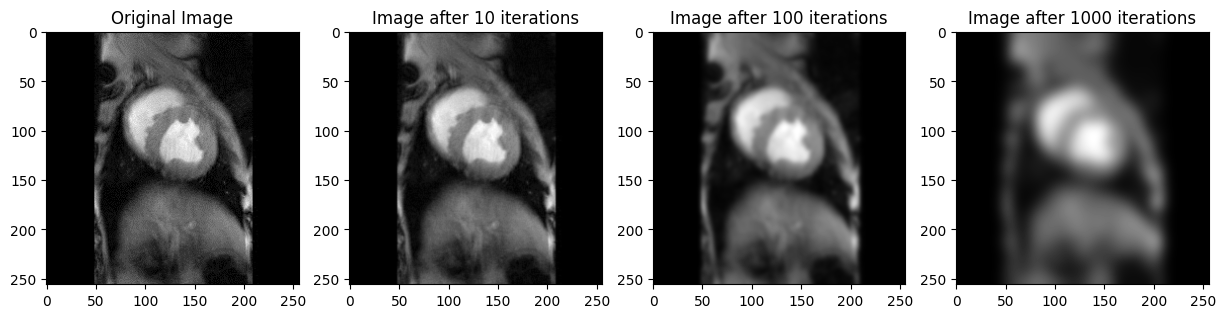

In [346]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('heart.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)

# diffusion coefficient
D = 0.1

# time step
dt = 0.1

show_iters = [10,100,1000]

x_second_derivative = np.array([[1,-2,1]])
y_second_derivative = x_second_derivative.T

fig, axs = plt.subplots(1,4, figsize=(15, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
subplot = 1

# Apply the heat equation for 1001 iterations
for n in range(1001):

    ## Second derivative of image in the x-direction
    img_xx = cv2.filter2D(src=img, ddepth=-1, kernel=x_second_derivative)

    ## Second derivative of image in the y-direction
    img_yy = cv2.filter2D(src=img, ddepth=-1, kernel=y_second_derivative)

    # Apply the discretized heat equation
    img += D * dt * (img_xx*2 + img_yy*2)
    if n in show_iters:
      axs[subplot].imshow(img, cmap='gray')
      axs[subplot].set_title('Image after ' + str(n) + ' iterations')
      subplot += 1

We can see that the images are getting blurred as we have applied some sort of Gaussian Filtering.



---



---



---

